In [1]:
import os 
from dotenv import load_dotenv, find_dotenv
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

load_dotenv(find_dotenv())

# connect to postgres
def pgconnect():
    try:
        conn = psycopg2.connect(database=os.environ.get("erdatabase"),
                                user=os.environ.get("eruser"),
                                password = os.environ.get("erpassword"),
                                host=os.environ.get("erhost"),
                                port=os.environ.get("erport"))
        print("Opened database successfully")
        return conn
    
    except psycopg2.Error as e:
        print("I am unable to connect to the database")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

In [2]:
def pgquery(QUERY):
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    conn = pgconnect()
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        # Create the dataframe, passing in the list of col_names extracted from the description
        conn.close()
        return pd.DataFrame(D, columns=col_names)

    except Exception as e:
        print(e.pgerror)
        conn.close()

In [3]:
# This function will return a reshaped dataframe that contains the following columns:
#
# incident_id | responderunit_id | responder_id | typenaturecode_id | fireblock | t1 | t2 |  ...
# where t1, t2, ... , tn are the timedesc_id that we are looking for.
#
# usage: getTimeDataset(timedesc_dict)
#
# param: timedesc_dict - keys are the timedesc_ids you want
#                      - values are the human descriptions for them 
# known issues: this eliminates "responder_id" (so we can probably just get rid of it in the query)
#               responder_id values were inconsistent and strange, so I decided to just ignore them
#               when doing anaylsis.
def getTimeDataset(timedesc_dict):
    RESPONSE_TIME_QUERY='''
                        SELECT  I.incident_id, R.responderunit_id, T.responder_id,
                                T.timedesc_id, I.typenaturecode_id, I.fireblock, I.fmarespcomp,
                                T.realtime
                        FROM incident as I
                        INNER JOIN inctimes as T
                                ON I.incident_id = T.incident_id
                        INNER JOIN responder as R
                                ON ( I.incident_id = R.incident_id AND T.responder_id = R.responder_id)
                        WHERE T.timedesc_id IN ??TIMEDESC_IDS??
                                AND T.responder_id IS NOT NULL;
                        '''
    
    # add the timedesc_ids that we want to the query
    timedesc_ids = str(tuple(timedesc_dict.keys())).replace("'", "")
    RESPONSE_TIME_QUERY = RESPONSE_TIME_QUERY.replace("??TIMEDESC_IDS??", str(timedesc_ids))
    
    # execute the query: **this takes a pretty long time**
    df = pgquery(RESPONSE_TIME_QUERY)
    
    # now reshape the data so that we can do analysis more easily. 
    table = df.pivot_table(index=['incident_id', 'responderunit_id', 'typenaturecode_id',
                                  'fireblock', 'fmarespcomp'],
                      columns='timedesc_id', values='realtime', aggfunc='first')
    table.rename(columns=timedesc_dict, inplace=True)
    
    return table

##### We are interested in calculating Response Time, which is the time it takes from 'Dispatch' to 'On Scene' for the firefighters.

In [59]:
d = {3 : 'Dispatched', 5 : 'On Scene'}
table = getTimeDataset(d)

Opened database successfully
SQL QUERY = 
                        SELECT  I.incident_id, R.responderunit_id, T.responder_id,
                                T.timedesc_id, I.typenaturecode_id, I.fireblock, I.fmarespcomp,
                                T.realtime
                        FROM incident as I
                        INNER JOIN inctimes as T
                                ON I.incident_id = T.incident_id
                        INNER JOIN responder as R
                                ON ( I.incident_id = R.incident_id AND T.responder_id = R.responder_id)
                        WHERE T.timedesc_id IN (3, 5)
                                AND T.responder_id IS NOT NULL;
                        


In [60]:
# take a look at the results.
table.head(20)

timedesc_id                                                                   Dispatched  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03          2010-01-01 00:07:32   
            221.0            147.0             0375      03          2010-01-01 00:07:32   
754222      58.0             134.0             0727      07          2010-01-01 00:04:24   
            218.0            134.0             0727      07          2010-01-01 00:04:24   
754224      232.0            21.0              1109      11          2010-01-01 00:14:15   
            415.0            21.0              1109      11          2010-01-01 00:14:15   
754225      120.0            125.0             2530      25          2010-01-01 00:16:21   
            229.0            125.0             2530      25          2010-01-01 00:16:21   
754226      56.0             141.0             0133      01          2010-01-01 00:21:17   
            123.0            141.0             0133      01          2010-01-01 00:22:11   
            218.0            141.0             0133      01          2010-01-01 00:21:17   
            230.0            141.0             0133      01          2010-01-01 00:23:33   
754227      30.0             141.0             0109      01          2010-01-01 00:09:02   
            215.0            141.0             0109      01          2010-01-01 00:09:02   
754228      33.0             12.0              0127      01          2010-01-01 00:17:31   
            116.0            12.0              0127      01          2010-01-01 00:17:31   
754229      46.0             147.0             2530      25          2010-01-01 00:19:21   
            218.0            147.0             2530      25          2010-01-01 00:21:26   
            230.0            147.0             2530      25          2010-01-01 00:19:21   
754230      116.0            155.0             0127      01          2010-01-01 00:25:34   

timedesc_id                                                                     On Scene  
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                      
754221      52.0             147.0             0375      03                          NaT  
            221.0            147.0             0375      03          2010-01-01 00:09:53  
754222      58.0             134.0             0727      07          2010-01-01 00:08:57  
            218.0            134.0             0727      07          2010-01-01 00:07:14  
754224      232.0            21.0              1109      11          2010-01-01 00:17:01  
            415.0            21.0              1109      11          2010-01-01 00:17:36  
754225      120.0            125.0             2530      25                          NaT  
            229.0            125.0             2530      25          2010-01-01 00:26:53  
754226      56.0             141.0             0133      01          2010-01-01 00:27:50  
            123.0            141.0             0133      01          2010-01-01 00:22:56  
            218.0            141.0             0133      01                          NaT  
            230.0            141.0             0133      01          2010-01-01 00:30:27  
754227      30.0             141.0             0109      01          2010-01-01 00:17:39  
            215.0            141.0             0109      01          2010-01-01 00:19:38  
754228      33.0             12.0              0127      01                          NaT  
            116.0            12.0              0127      01          2010-01-01 00:23:24  
754229      46.0             147.0             2530      25          2010-01-01 00:25:06  
            218.0            147.0             2530      25                          NaT  
            230.0            147.0             2530      25                          NaT  
754230      116.0            155.0             0127      01     

In [61]:
table["difference"] = table['On Scene'].sub(table['Dispatched'], axis = 0)
table["difference"].astype('timedelta64[s]')
table.head(20)

timedesc_id                                                                   Dispatched  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03          2010-01-01 00:07:32   
            221.0            147.0             0375      03          2010-01-01 00:07:32   
754222      58.0             134.0             0727      07          2010-01-01 00:04:24   
            218.0            134.0             0727      07          2010-01-01 00:04:24   
754224      232.0            21.0              1109      11          2010-01-01 00:14:15   
            415.0            21.0              1109      11          2010-01-01 00:14:15   
754225      120.0            125.0             2530      25          2010-01-01 00:16:21   
            229.0            125.0             2530      25          2010-01-01 00:16:21   
754226      56.0             141.0             0133      01          2010-01-01 00:21:17   
            123.0            141.0             0133      01          2010-01-01 00:22:11   
            218.0            141.0             0133      01          2010-01-01 00:21:17   
            230.0            141.0             0133      01          2010-01-01 00:23:33   
754227      30.0             141.0             0109      01          2010-01-01 00:09:02   
            215.0            141.0             0109      01          2010-01-01 00:09:02   
754228      33.0             12.0              0127      01          2010-01-01 00:17:31   
            116.0            12.0              0127      01          2010-01-01 00:17:31   
754229      46.0             147.0             2530      25          2010-01-01 00:19:21   
            218.0            147.0             2530      25          2010-01-01 00:21:26   
            230.0            147.0             2530      25          2010-01-01 00:19:21   
754230      116.0            155.0             0127      01          2010-01-01 00:25:34   

timedesc_id                                                                     On Scene  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03                          NaT   
            221.0            147.0             0375      03          2010-01-01 00:09:53   
754222      58.0             134.0             0727      07          2010-01-01 00:08:57   
            218.0            134.0             0727      07          2010-01-01 00:07:14   
754224      232.0            21.0              1109      11          2010-01-01 00:17:01   
            415.0            21.0              1109      11          2010-01-01 00:17:36   
754225      120.0            125.0             2530      25                          NaT   
            229.0            125.0             2530      25          2010-01-01 00:26:53   
754226      56.0             141.0             0133      01          2010-01-01 00:27:50   
            123.0            141.0             0133      01          2010-01-01 00:22:56   
            218.0            141.0             0133      01                          NaT   
            230.0            141.0             0133      01          2010-01-01 00:30:27   
754227      30.0             141.0             0109      01          2010-01-01 00:17:39   
            215.0            141.0             0109      01          2010-01-01 00:19:38   
754228      33.0             12.0              0127      01                          NaT   
            116.0            12.0              0127      01          2010-01-01 00:23:24   
754229      46.0             147.0             2530      25          2010-01-01 00:25:06   
            218.0            147.0             2530      25                          NaT   
            230.0            147.0             2530      25                          NaT   
754230      116.0            155.0         

In [62]:
table["diff_min"] = (table["difference"] / pd.Timedelta(minutes=1, seconds=0))
table.head(10)

timedesc_id                                                                   Dispatched  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03          2010-01-01 00:07:32   
            221.0            147.0             0375      03          2010-01-01 00:07:32   
754222      58.0             134.0             0727      07          2010-01-01 00:04:24   
            218.0            134.0             0727      07          2010-01-01 00:04:24   
754224      232.0            21.0              1109      11          2010-01-01 00:14:15   
            415.0            21.0              1109      11          2010-01-01 00:14:15   
754225      120.0            125.0             2530      25          2010-01-01 00:16:21   
            229.0            125.0             2530      25          2010-01-01 00:16:21   
754226      56.0             141.0             0133      01          2010-01-01 00:21:17   
            123.0            141.0             0133      01          2010-01-01 00:22:11   

timedesc_id                                                                     On Scene  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03                          NaT   
            221.0            147.0             0375      03          2010-01-01 00:09:53   
754222      58.0             134.0             0727      07          2010-01-01 00:08:57   
            218.0            134.0             0727      07          2010-01-01 00:07:14   
754224      232.0            21.0              1109      11          2010-01-01 00:17:01   
            415.0            21.0              1109      11          2010-01-01 00:17:36   
754225      120.0            125.0             2530      25                          NaT   
            229.0            125.0             2530      25          2010-01-01 00:26:53   
754226      56.0             141.0             0133      01          2010-01-01 00:27:50   
            123.0            141.0             0133      01          2010-01-01 00:22:56   

timedesc_id                                                           difference  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp               
754221      52.0             147.0             0375      03                  NaT   
            221.0            147.0             0375      03             00:02:21   
754222      58.0             134.0             0727      07             00:04:33   
            218.0            134.0             0727      07             00:02:50   
754224      232.0            21.0              1109      11             00:02:46   
            415.0            21.0              1109      11             00:03:21   
754225      120.0            125.0             2530      25                  NaT   
            229.0            125.0             2530      25             00:10:32   
754226      56.0             141.0             0133      01             00:06:33   
            123.0            141.0             0133      01             00:00:45   

timedesc_id                                                            diff_min  
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp             
754221      52.0             147.0             0375      03                 NaN  
            221.0            147.0             0375      03            2.350000  
754222      58.0             134.0             0727      07            4.550000  
            218.0            134.0             0727      07            2.833333  
754224      232.0            21.0              1109      11            2.766667  
            415.0            21.0              1109      11            3.350000  
754225      120.0            125.0             2530      25                 NaN  
            229.0            125.0         

In [63]:
table.describe()

timedesc_id,difference,diff_min
count,889921,8.899210e+05
mean,-1 days +23:38:10.949737,-2.181750e+01
std,17 days 01:23:53.266197,2.456389e+04
min,-16071 days +00:03:54,-2.314224e+07
25%,0 days 00:03:58,3.966667e+00
50%,0 days 00:05:10,5.166667e+00
75%,0 days 00:06:38,6.633333e+00
max,70 days 06:14:30,1.011745e+05


#### Hmm.. It is interesting that we have negative time differences.. let's investigate those.

In [43]:
neg = table.loc[table['diff_min'] < 0.0]
neg.shape

(196, 4)

### Ok, so there are only a few rows with negative values (a couple hundred out of about a million rows). Let's just ignore those for now, and possibly look into them later.

### We also happen to have really, really large response time values (up to 70 days and 6 hours). These seem really odd, and we will also ignore those for now.

In [64]:
# keep only the response times from 0 minutes to a day
table = table.loc[table['diff_min'] >= 0.0].loc[table['diff_min'] <= 1440] # less than a day

/home/vagrant/miniconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


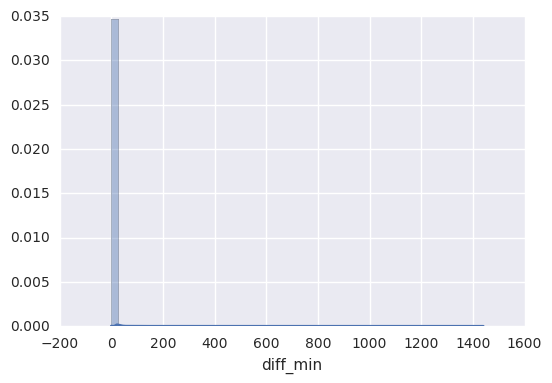

In [29]:
sns.distplot(table['diff_min'])

/home/vagrant/miniconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


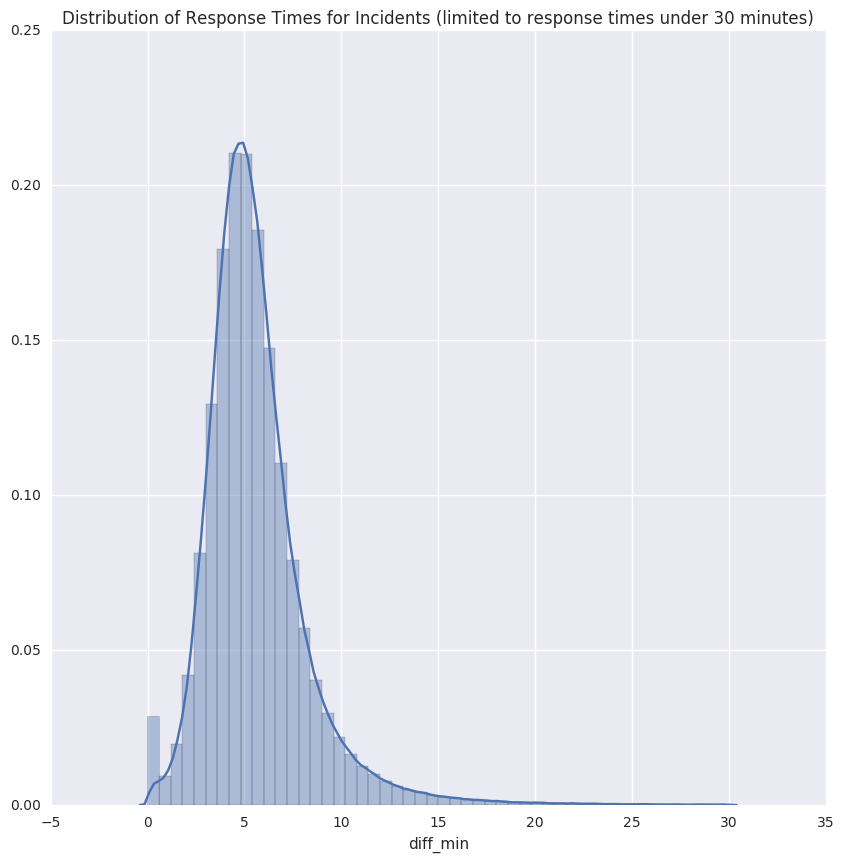

In [43]:
# zoom in on thirty minutes
plt.rcParams['figure.figsize']=(10,10)
sns.distplot(table.loc[table['diff_min'] <= 30]['diff_min']) 
plt.title('Distribution of Response Times for Incidents (limited to response times under 30 minutes)')

/home/vagrant/miniconda3/envs/data-science/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


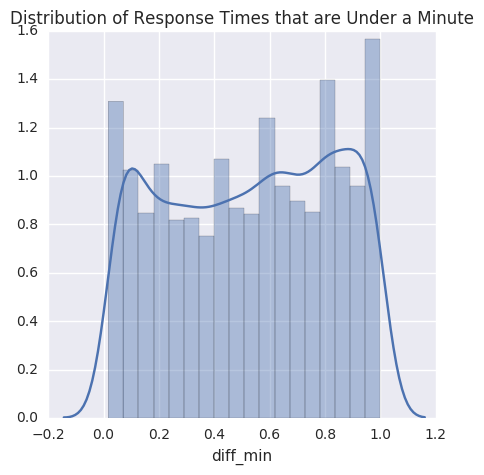

In [45]:
plt.rcParams['figure.figsize']=(5,5)
sns.distplot(table.loc[table['diff_min'] > 0.0].loc[table['diff_min'] <= 1]['diff_min'])
plt.title('Distribution of Response Times that are Under a Minute')

# Below, we take a look at median response times by FMA and Responder ID.

# 1. FMA

In [66]:
# take a look at the values for the FMAs in the incident table.
# notice that there are some values that do not correspond to the FMAs.
# we belive that some are typos and others might be actual FMAs, but
# not ones that PF&R regularly serves
table['fmarespcomp'] = table.index.get_level_values('fmarespcomp') 
fmaCounts = table.groupby(['fmarespcomp'])['diff_min'].count()
fmaCounts.head(100)

fmarespcomp
01         73696
02         22139
03         50950
04         48808
05         13164
06          3909
07         74860
08         22134
09         28078
1              1
10          5972
11         51763
12         27682
13         50038
14         32124
15          3874
16          7782
17         13447
18         20897
19         37248
20         17025
21         21229
210          234
22         23927
23         11875
24         25018
25         38828
26         20125
27          2370
28         26073
29         25156
30         36936
31         42734
32            83
61            31
62             4
62551          1
71          1012
72           424
73          1175
74          4077
75           332
76            64
89          1297
?              2
E64            2
GRESHAM        7
N/A            6
NA            12
NONE           1
OF           884
T53          135
T60           36
UK             6
UNK           10
UNKNOWN        3
Name: diff_min, dtype: int64

In [67]:
validFMAs = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10",
             "11", "12", "13", "14", "15", "16", "17", "18", "19", "20",
             "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31"]

In [68]:
# get the Median response times for the Valid FMA's.
fmaResponseTimes = table[table['fmarespcomp'].isin(validFMAs)].groupby(['fmarespcomp'])['diff_min'].median()
fmaResponseTimes.head(31)

fmarespcomp
01    4.616667
02    5.766667
03    4.866667
04    4.633333
05    6.133333
06    5.816667
07    5.066667
08    4.533333
09    5.100000
10    6.433333
11    4.883333
12    4.916667
13    4.916667
14    5.566667
15    6.408333
16    6.916667
17    6.916667
18    6.350000
19    4.950000
20    6.383333
21    4.833333
22    5.566667
23    5.966667
24    4.933333
25    5.333333
26    5.066667
27    9.016667
28    5.116667
29    5.933333
30    5.300000
31    5.233333
Name: diff_min, dtype: float64

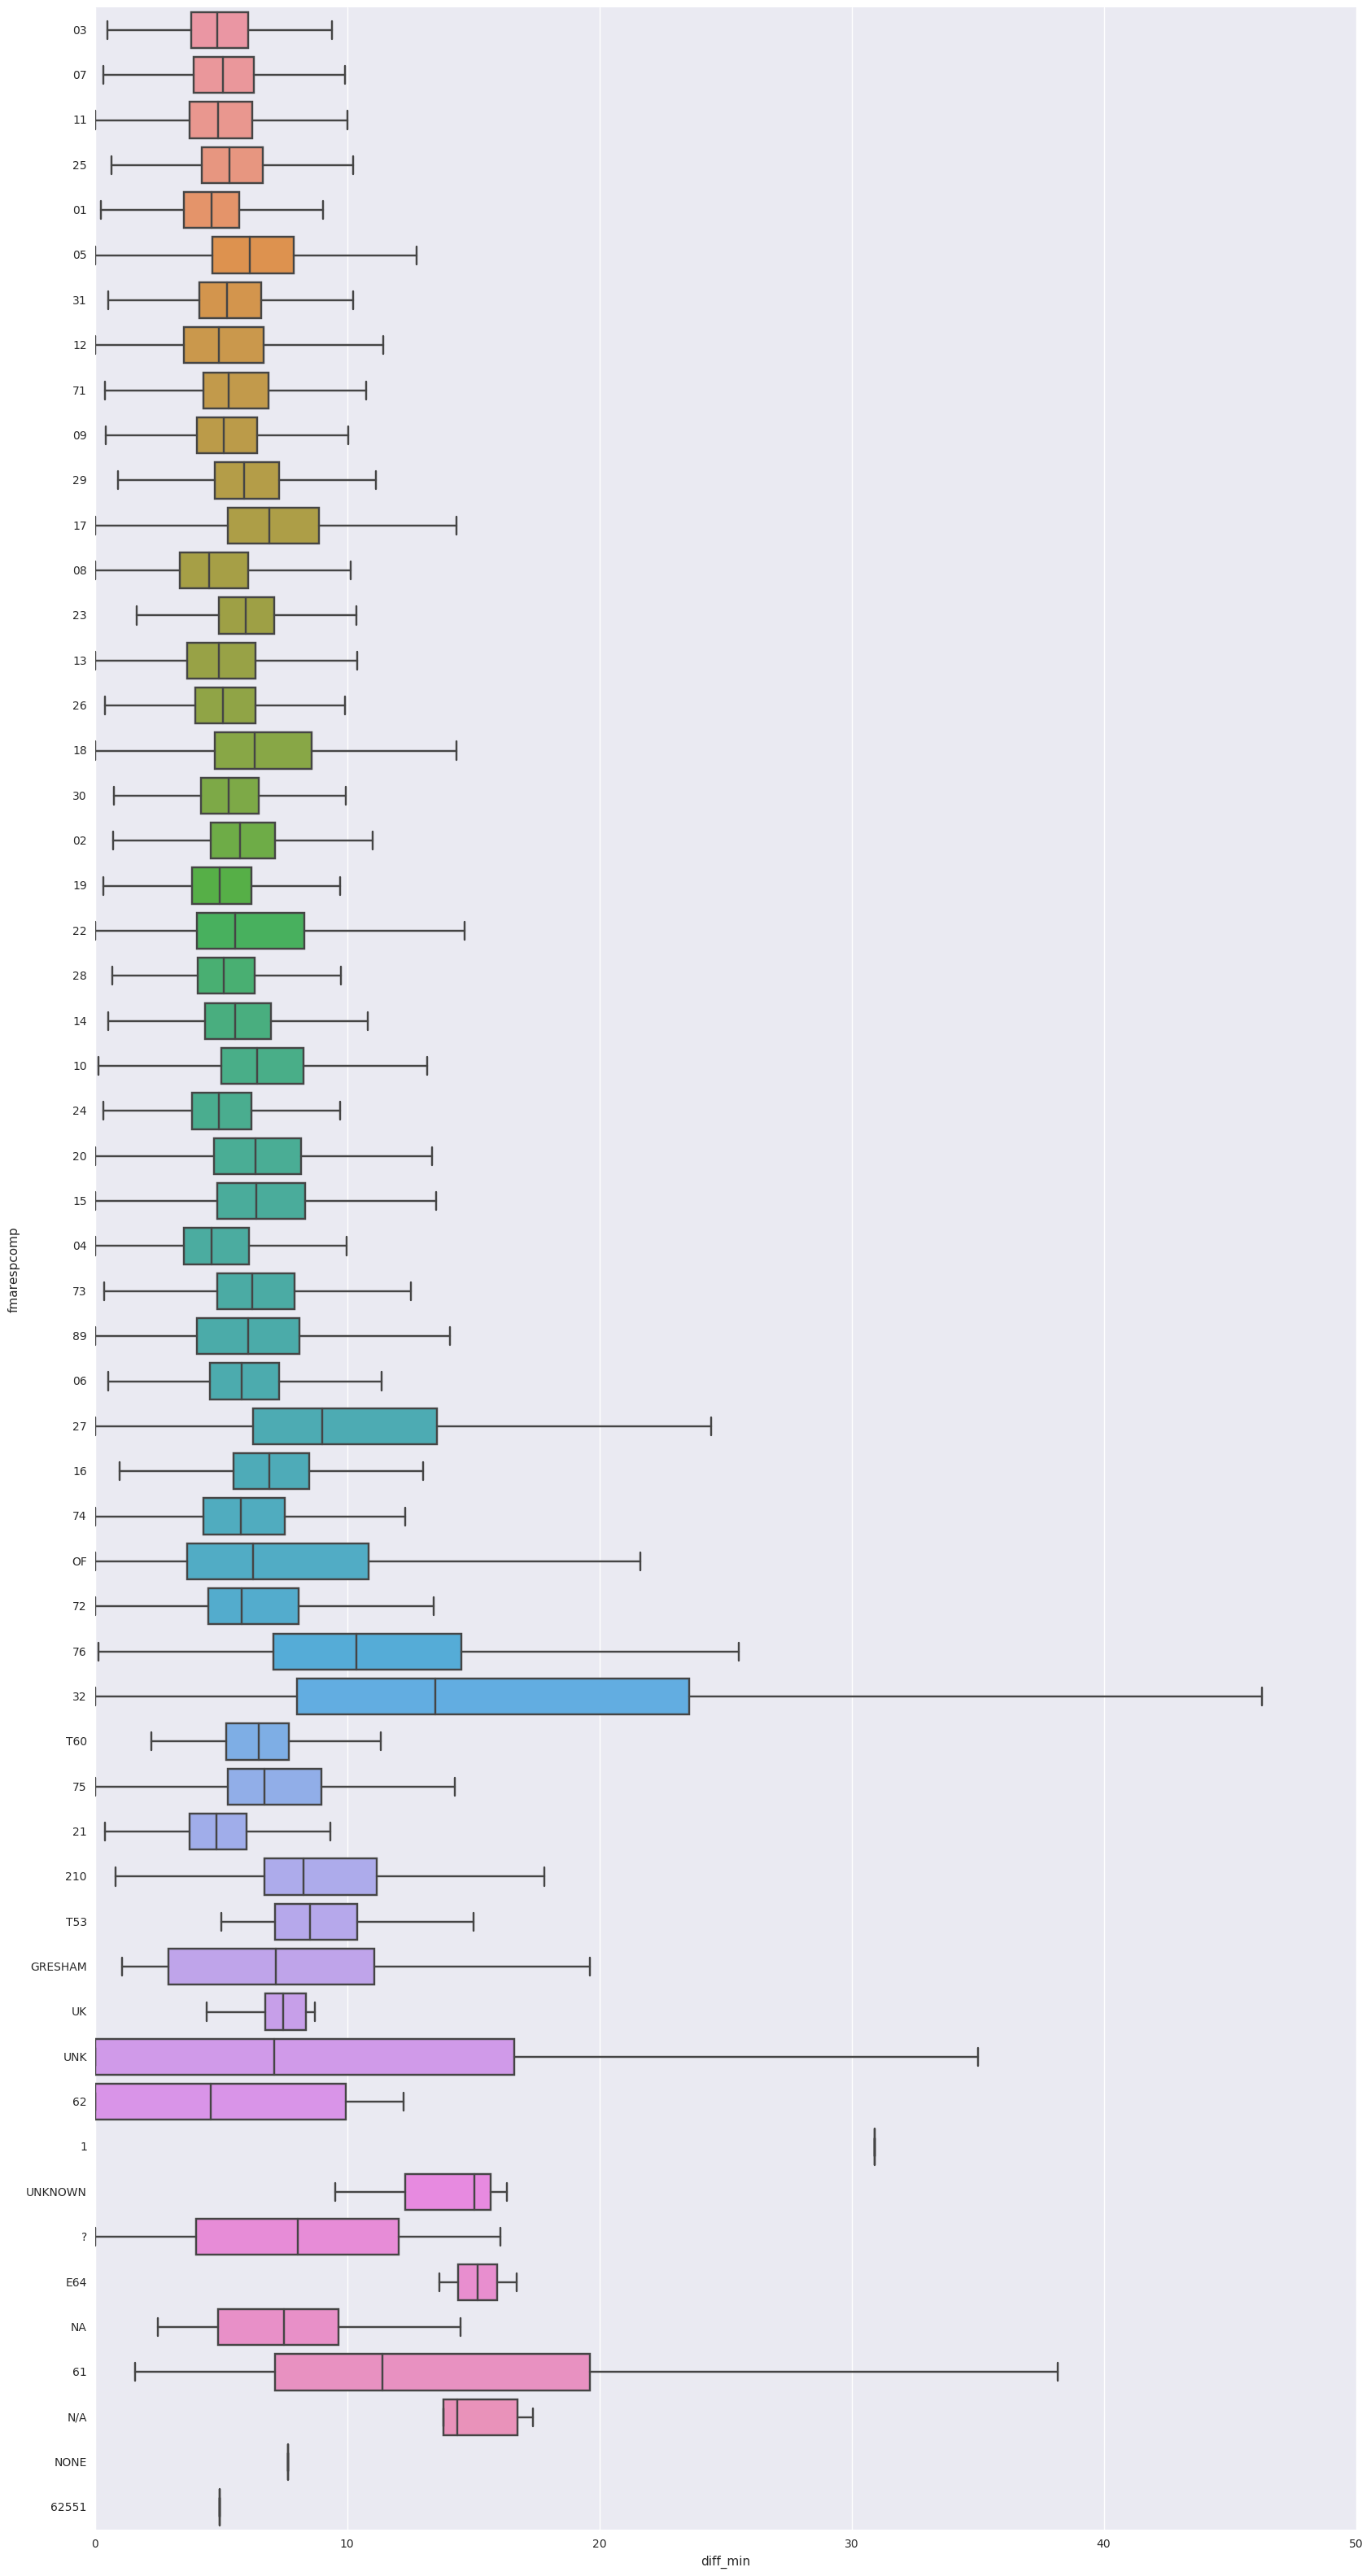

In [79]:
# ok, let's try and plot the response times by FMA
plt.rcParams['figure.figsize']=(20,40)
# draw boxplots, don't show outliers
ax1 = sns.boxplot(y="fmarespcomp", x="diff_min", data=table, showfliers=False) 

# 2. Responder Id

In [81]:
# take a look at the values for the responderunit_ids in the incident table.
table['responderunit_id'] = table.index.get_level_values('responderunit_id')
responderUnitCounts = table.groupby(['responderunit_id'])['diff_min'].count()
responderUnitCounts.head(100)

responderunit_id
4.0        108
7.0       1724
8.0        102
9.0       1131
10.0         8
12.0      2949
13.0      2780
14.0         4
15.0      2872
16.0         1
18.0         4
19.0         1
20.0         8
21.0        32
22.0        16
23.0         1
27.0         1
29.0        16
30.0     16973
31.0      3029
32.0     18064
33.0     17253
34.0     16232
35.0      3156
36.0      6591
37.0     10825
38.0     15688
39.0      6965
40.0      9551
42.0      7736
         ...  
102.0       13
103.0       33
104.0     1608
105.0       41
106.0      191
109.0      142
110.0     7188
113.0       40
114.0    12220
116.0    12182
117.0    11044
118.0     6104
119.0     5954
120.0    10518
122.0    11076
123.0    10825
124.0    14865
125.0      618
127.0     8819
130.0        5
137.0        7
138.0        1
139.0        1
140.0       50
144.0        1
146.0       15
148.0       16
152.0        8
156.0        1
157.0        1
Name: diff_min, dtype: int64

In [82]:
responderResponseTimes = table[table['fmarespcomp'].isin(validFMAs)].groupby(['responderunit_id'])['diff_min'].median()
responderResponseTimes.head(31)

responderunit_id
4.0     8.716667
7.0     6.983333
8.0     0.300000
9.0     4.366667
10.0    3.316667
12.0    6.358333
13.0    5.433333
14.0    0.000000
15.0    7.483333
19.0    0.000000
21.0    6.600000
22.0    2.450000
27.0    2.283333
29.0    8.808333
30.0    4.166667
31.0    6.283333
32.0    5.000000
33.0    4.416667
34.0    5.016667
35.0    5.850000
36.0    6.150000
37.0    5.750000
38.0    4.983333
39.0    5.516667
40.0    5.166667
42.0    5.016667
44.0    5.141667
45.0    4.666667
46.0    5.133333
51.0    4.716667
52.0    4.466667
Name: diff_min, dtype: float64

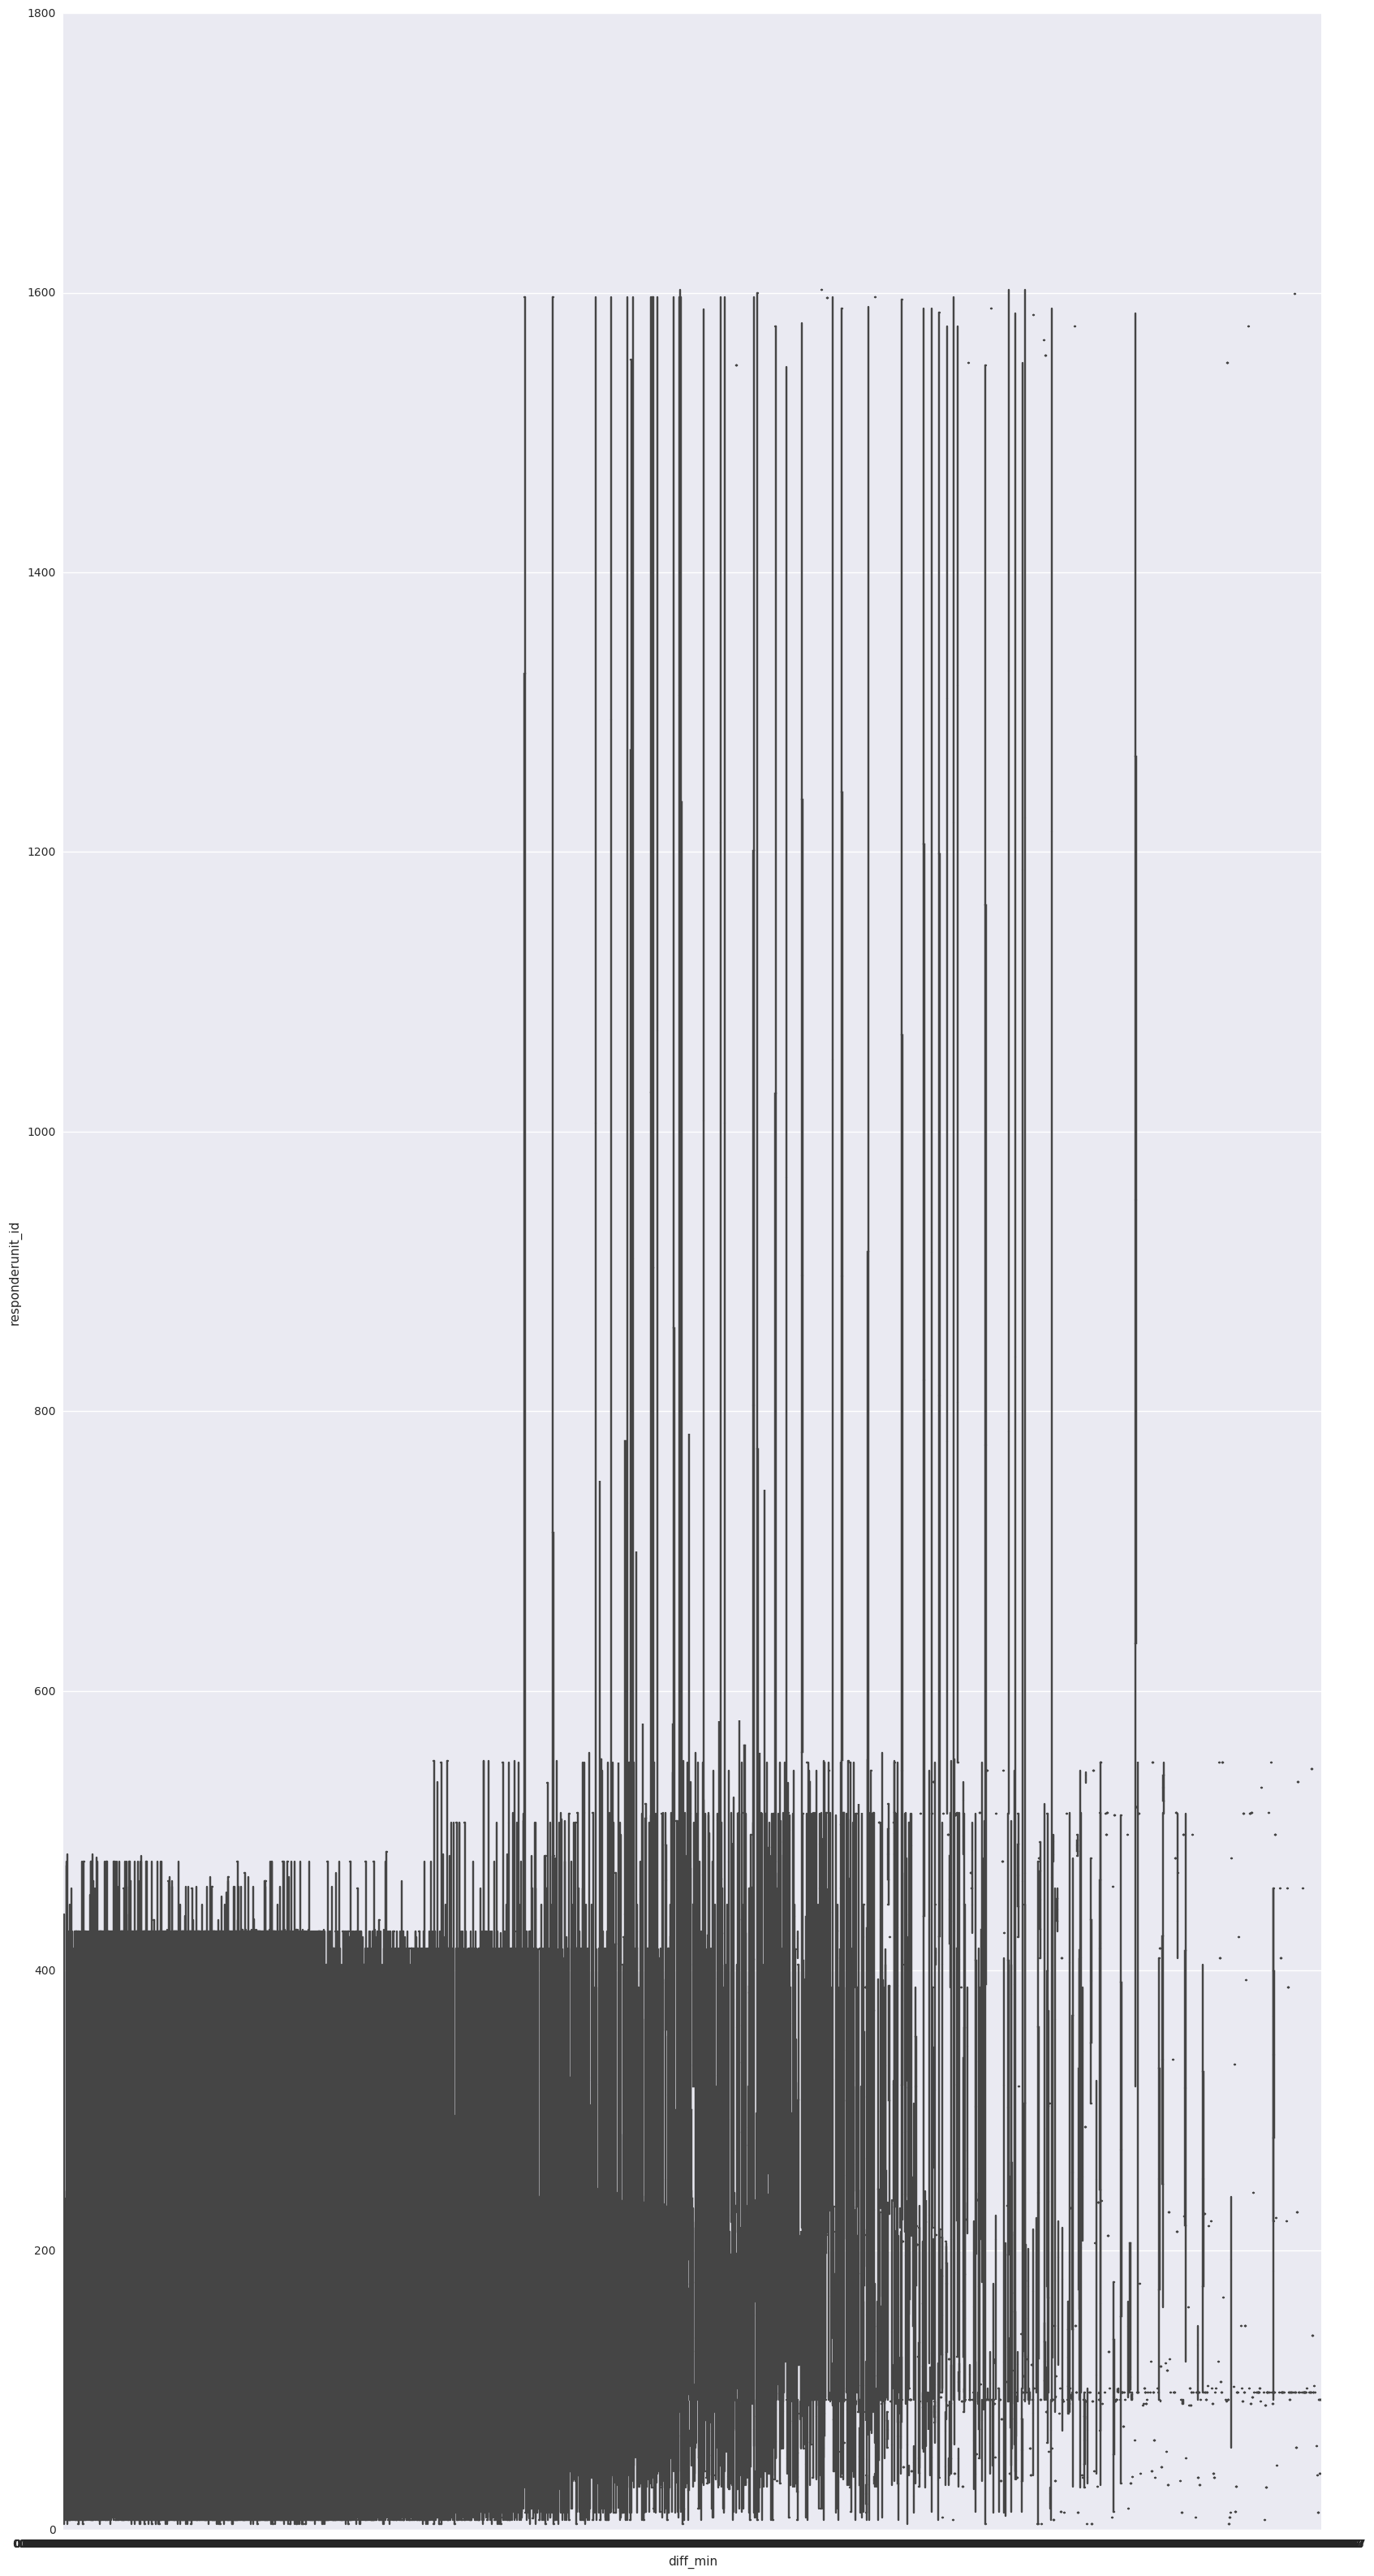

In [83]:
# figure out how to do this properly.
plt.rcParams['figure.figsize']=(10,10)

ax2 = sns.boxplot(y="responderunit_id", x="diff_min", data=table, showfliers=False) 